# Synthetic Neural Manifolds

### Set Up + Imports

In [418]:
import setup
setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot circle $\mathcal{S}^1$ and $N=3$ encoding vectors



We will project latent manifold $\mathcal{S}^1$ (minimal embedding dimension $d=2$) into $N$-dimensional neural state space ($N=3$) with a $d\times N$ matrix $A$. The entries of $A$ are randomly sampled from a uniform distribution $U[-1,1]$ and its columns are random encoding vectors. 

In [429]:
num_points = 1000
data = synthetic.hypersphere(1, num_points)

x = data[:, 0]
y = data[:, 1]
z = np.zeros(num_points)

angles = torch.atan2(data[:, 1], data[:, 0])
normalized_angles = angles / (2 * np.pi) + 1 / 2
colors = plt.cm.hsv(normalized_angles)

N = 3
place_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
encoding_matrix = gs.vstack((gs.cos(place_angles), gs.sin(place_angles)))
vectors = [encoding_matrix[:, i] for i in range(N)]

cm = plt.get_cmap("twilight")
vector_colors = [cm(1.0 * i / N) for i in range(N)]
vector_colors = [
    "rgb({}, {}, {})".format(int(r * 255), int(g * 255), int(b * 255))
    for r, g, b, _ in vector_colors
]

scatter1 = go.Scatter3d(
    x=x, y=y, z=z, mode="markers", marker=dict(size=5, color=colors), name="Data Points"
)

lines_and_cones = []
for idx, (vector, color) in enumerate(zip(vectors, vector_colors)):
    lines_and_cones.append(
        go.Scatter3d(
            x=[0, vector[0]],
            y=[0, vector[1]],
            z=[0, 0],
            mode="lines",
            line=dict(color=color, width=5),
            name=f"Encoding Vector {idx+1}",
        )
    )
    lines_and_cones.append(
        go.Cone(
            x=[vector[0]],
            y=[vector[1]],
            z=[0],
            u=[vector[0] / 10],
            v=[vector[1] / 10],
            w=[0],
            showscale=False,
            colorscale=[[0, color], [1, color]],
            sizemode="absolute",
            sizeref=0.1,
        )
    )

# Your existing setup for the second plot
transformed_encoding_vectors = synthetic.encode_points(
    encoding_matrix.T, encoding_matrix
)
encoded_data = synthetic.encode_points(data, encoding_matrix)
scales = gs.array([5, 3, 1])
sigmoid_data = synthetic.apply_nonlinearity(encoded_data, "sigmoid", scales=scales)

x = sigmoid_data[:, 0]
y = sigmoid_data[:, 1]
z = sigmoid_data[:, 2]

scatter2 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode="markers",
    marker=dict(size=5, color=colors),
    name="Neural activations",
)

# Create a subplot with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
)

# Add the first set of traces (scatter1 and lines_and_cones) to the first subplot
fig.add_traces(
    [scatter1] + lines_and_cones,
    rows=[1] * (len([scatter1]) + len(lines_and_cones)),
    cols=[1] * (len([scatter1]) + len(lines_and_cones)),
)

# Add the second scatter (scatter2) to the second subplot
fig.add_trace(scatter2, row=1, col=2)

# Update layout for each subplot
fig.update_layout(
    scene1=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
        zaxis=dict(range=[-1.2, 1.2], title=""),
    ),
    scene2=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Neuron 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Neuron 2"),
        zaxis=dict(range=[-1.2, 1.2], title="Neuron 3"),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    title_text="",
    annotations=[
        dict(
            text="Feature Space",
            xref="paper",
            yref="paper",
            x=0.25,
            y=0.95,
            showarrow=False,
            font=dict(size=20),
        ),
        dict(
            text="Neural Space",
            xref="paper",
            yref="paper",
            x=0.75,
            y=0.95,
            showarrow=False,
            font=dict(size=20),
        ),
    ],
)


fig.show()

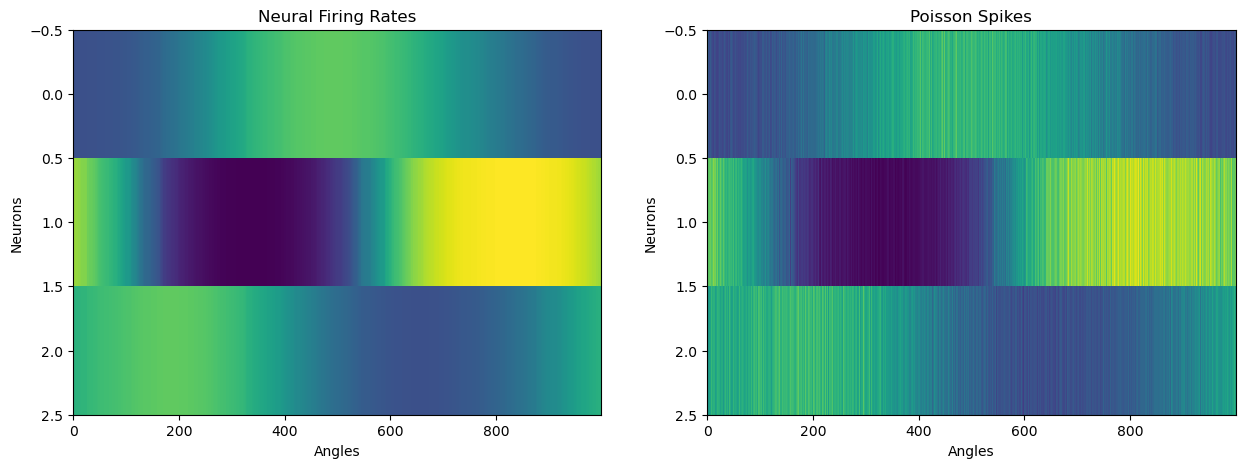

In [432]:
encoded_data = synthetic.encode_points(data, encoding_matrix)


scales = gs.array([1, 3, 1])
sigmoid_data = synthetic.apply_nonlinearity(encoded_data, "sigmoid", scales=scales)

sorted_indices = torch.argsort(angles)
sorted_data_by_angles = sigmoid_data[sorted_indices, :]

poisson_data = torch.poisson(500 * sorted_data_by_angles)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(sorted_data_by_angles.T, aspect="auto", interpolation="none")
axs[0].set_xlabel("Angles")
axs[0].set_ylabel("Neurons")
axs[0].set_title("Neural Firing Rates")

axs[1].imshow(poisson_data.T, aspect="auto", interpolation="none")
axs[1].set_xlabel("Angles")
axs[1].set_ylabel("Neurons")
axs[1].set_title("Poisson Spikes");

### Visualize cylinder ($\mathcal{S}^1 \times [0,1]$)

In [423]:
cylinder_points = synthetic.cylinder(num_points)

x = cylinder_points[:, 0]
y = cylinder_points[:, 1]
z = cylinder_points[:, 2]

scatter = go.Scatter3d(x=x, y=y, z=z, mode="markers", marker=dict(size=5))


fig = go.Figure(data=[scatter])

fig.update_layout(
    title={
        "text": "Cylinder",
        "y": 0.5,
        "x": 0.1,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=25),
    },
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
        zaxis=dict(range=[-1.2, 1.2], title="Feature 3"),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()

In [428]:
synthetic.scaled_sigmoid(gs.array([[-1]]), gs.array([3]))

tensor([[0.0474]])